# Enhanced Code Labeling Dataset
## Automatic Emotion Labeling with Quality Validation

This enhanced version includes:
- Text preprocessing
- Quality validation metrics
- Cluster content analysis
- Error handling
- Hyperparameter tuning
- Comprehensive reporting

In [1]:
# Install required packages
!pip install sentence-transformers scikit-learn matplotlib seaborn wordcloud

   ---------------------------------------- 0.0/306.1 kB ? eta -:--:--
   - -------------------------------------- 10.2/306.1 kB ? eta -:--:--
   --- ----------------------------------- 30.7/306.1 kB 660.6 kB/s eta 0:00:01
   ------------------ --------------------- 143.4/306.1 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 306.1/306.1 kB 2.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import logging
import warnings
from pathlib import Path
from typing import Optional, Dict, List, Tuple
from collections import Counter

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from wordcloud import WordCloud

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Setup plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

c:\Users\Jeremy Wijaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries imported successfully


In [3]:
# Configuration
CONFIG = {
    'input_file': '../data/raw/dataset_clean.csv',
    'output_file': '../data/raw/dataset_with_mood_enhanced.csv',
    'model_name': 'all-MiniLM-L6-v2',
    'text_column': 'caption_desc',
    'max_clusters': 8,
    'min_clusters': 2,
    'batch_size': 1000,
    'random_state': 42,
    'sample_size_for_analysis': 20
}

print("📋 Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

📋 Configuration loaded:
  input_file: ../data/raw/dataset_clean.csv
  output_file: ../data/raw/dataset_with_mood_enhanced.csv
  model_name: all-MiniLM-L6-v2
  text_column: caption_desc
  max_clusters: 8
  min_clusters: 2
  batch_size: 1000
  random_state: 42
  sample_size_for_analysis: 20


In [4]:
def preprocess_text(text: str) -> str:
    """
    Clean and preprocess text for better embedding quality.
    
    Args:
        text: Raw text string
        
    Returns:
        Cleaned text string
    """
    if pd.isna(text) or text == '':
        return ""
    
    # Convert to string if not already
    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Keep emoticons and emojis (they're important for emotion detection)
    # Remove special characters but keep emoticons
    text = re.sub(r'[^\w\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF:;=()\-\[\]{}]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove very short texts (likely noise)
    if len(text.strip()) < 3:
        return ""
    
    return text.strip()

def validate_dataframe(df: pd.DataFrame, text_column: str) -> bool:
    """
    Validate input dataframe.
    
    Args:
        df: Input dataframe
        text_column: Name of text column
        
    Returns:
        True if valid, False otherwise
    """
    if df is None or df.empty:
        logger.error("DataFrame is empty or None")
        return False
    
    if text_column not in df.columns:
        logger.error(f"Column '{text_column}' not found in DataFrame")
        logger.info(f"Available columns: {list(df.columns)}")
        return False
    
    # Check for too many missing values
    missing_ratio = df[text_column].isna().sum() / len(df)
    if missing_ratio > 0.5:
        logger.warning(f"High missing value ratio: {missing_ratio:.2%}")
    
    return True

print("🔧 Preprocessing functions defined")

🔧 Preprocessing functions defined


In [5]:
def safe_load_model(model_name: str) -> Optional[SentenceTransformer]:
    """
    Safely load sentence transformer model with error handling.
    
    Args:
        model_name: Name of the model to load
        
    Returns:
        Loaded model or None if failed
    """
    try:
        logger.info(f"Loading model: {model_name}")
        model = SentenceTransformer(model_name)
        logger.info(f"✅ Model {model_name} loaded successfully")
        return model
    except Exception as e:
        logger.error(f"❌ Failed to load model {model_name}: {e}")
        return None

def safe_encode_batch(model: SentenceTransformer, texts: List[str], batch_size: int = 1000) -> np.ndarray:
    """
    Safely encode texts in batches with error handling.
    
    Args:
        model: Loaded sentence transformer model
        texts: List of texts to encode
        batch_size: Size of each batch
        
    Returns:
        Array of embeddings
    """
    embeddings = []
    failed_batches = []
    
    logger.info(f"Encoding {len(texts)} texts in batches of {batch_size}")
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_num = i // batch_size + 1
        total_batches = (len(texts) + batch_size - 1) // batch_size
        
        try:
            logger.info(f"Processing batch {batch_num}/{total_batches}")
            batch_embeddings = model.encode(batch, show_progress_bar=True)
            embeddings.extend(batch_embeddings)
        except Exception as e:
            logger.error(f"Failed to encode batch {batch_num}: {e}")
            failed_batches.append(batch_num)
            # Add zero embeddings for failed batch to maintain alignment
            zero_embeddings = np.zeros((len(batch), model.get_sentence_embedding_dimension()))
            embeddings.extend(zero_embeddings)
    
    if failed_batches:
        logger.warning(f"Failed batches: {failed_batches}")
    
    return np.array(embeddings)

print("🤖 Model functions defined")

🤖 Model functions defined


In [6]:
def find_optimal_clusters(embeddings: np.ndarray, min_clusters: int = 2, max_clusters: int = 10) -> Tuple[int, Dict]:
    """
    Find optimal number of clusters using multiple metrics.
    
    Args:
        embeddings: Array of embeddings
        min_clusters: Minimum number of clusters to test
        max_clusters: Maximum number of clusters to test
        
    Returns:
        Optimal number of clusters and metrics dictionary
    """
    metrics = {
        'n_clusters': [],
        'silhouette_scores': [],
        'calinski_scores': [],
        'inertias': []
    }
    
    logger.info(f"Testing cluster numbers from {min_clusters} to {max_clusters}")
    
    for n_clusters in range(min_clusters, max_clusters + 1):
        try:
            kmeans = KMeans(n_clusters=n_clusters, random_state=CONFIG['random_state'], n_init='auto')
            cluster_labels = kmeans.fit_predict(embeddings)
            
            silhouette_avg = silhouette_score(embeddings, cluster_labels)
            calinski_score = calinski_harabasz_score(embeddings, cluster_labels)
            
            metrics['n_clusters'].append(n_clusters)
            metrics['silhouette_scores'].append(silhouette_avg)
            metrics['calinski_scores'].append(calinski_score)
            metrics['inertias'].append(kmeans.inertia_)
            
            logger.info(f"n_clusters={n_clusters}: silhouette={silhouette_avg:.3f}, calinski={calinski_score:.1f}")
            
        except Exception as e:
            logger.error(f"Failed clustering with {n_clusters} clusters: {e}")
            continue
    
    # Find optimal based on silhouette score
    if metrics['silhouette_scores']:
        optimal_idx = np.argmax(metrics['silhouette_scores'])
        optimal_clusters = metrics['n_clusters'][optimal_idx]
        logger.info(f"✅ Optimal clusters: {optimal_clusters} (silhouette score: {metrics['silhouette_scores'][optimal_idx]:.3f})")
    else:
        optimal_clusters = 4  # fallback
        logger.warning("Using fallback: 4 clusters")
    
    return optimal_clusters, metrics

def plot_clustering_metrics(metrics: Dict):
    """
    Plot clustering evaluation metrics.
    
    Args:
        metrics: Dictionary containing clustering metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Clustering Evaluation Metrics', fontsize=16, fontweight='bold')
    
    # Silhouette Score
    axes[0, 0].plot(metrics['n_clusters'], metrics['silhouette_scores'], 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_title('Silhouette Score (Higher is Better)', fontweight='bold')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Calinski-Harabasz Score
    axes[0, 1].plot(metrics['n_clusters'], metrics['calinski_scores'], 'ro-', linewidth=2, markersize=8)
    axes[0, 1].set_title('Calinski-Harabasz Score (Higher is Better)', fontweight='bold')
    axes[0, 1].set_xlabel('Number of Clusters')
    axes[0, 1].set_ylabel('Calinski-Harabasz Score')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Elbow Method (Inertia)
    axes[1, 0].plot(metrics['n_clusters'], metrics['inertias'], 'go-', linewidth=2, markersize=8)
    axes[1, 0].set_title('Elbow Method - Inertia (Lower is Better)', fontweight='bold')
    axes[1, 0].set_xlabel('Number of Clusters')
    axes[1, 0].set_ylabel('Inertia')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Combined normalized scores
    if len(metrics['silhouette_scores']) > 0:
        # Normalize scores to 0-1 range
        sil_norm = np.array(metrics['silhouette_scores'])
        sil_norm = (sil_norm - sil_norm.min()) / (sil_norm.max() - sil_norm.min())
        
        cal_norm = np.array(metrics['calinski_scores'])
        cal_norm = (cal_norm - cal_norm.min()) / (cal_norm.max() - cal_norm.min())
        
        combined = (sil_norm + cal_norm) / 2
        
        axes[1, 1].plot(metrics['n_clusters'], combined, 'mo-', linewidth=2, markersize=8, label='Combined Score')
        axes[1, 1].plot(metrics['n_clusters'], sil_norm, 'b--', alpha=0.7, label='Silhouette (norm)')
        axes[1, 1].plot(metrics['n_clusters'], cal_norm, 'r--', alpha=0.7, label='Calinski (norm)')
        axes[1, 1].set_title('Combined Normalized Scores', fontweight='bold')
        axes[1, 1].set_xlabel('Number of Clusters')
        axes[1, 1].set_ylabel('Normalized Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('clustering_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

print("📊 Clustering functions defined")

📊 Clustering functions defined


In [7]:
def analyze_cluster_content(df: pd.DataFrame, clusters: np.ndarray, embeddings: np.ndarray, 
                          kmeans: KMeans, text_column: str, sample_size: int = 20) -> Dict:
    """
    Analyze content of each cluster to understand what they represent.
    
    Args:
        df: DataFrame with text data
        clusters: Cluster assignments
        embeddings: Text embeddings
        kmeans: Fitted KMeans model
        text_column: Name of text column
        sample_size: Number of samples to analyze per cluster
        
    Returns:
        Dictionary with cluster analysis
    """
    cluster_analysis = {}
    num_clusters = len(np.unique(clusters))
    
    logger.info(f"Analyzing content of {num_clusters} clusters")
    
    for i in range(num_clusters):
        cluster_mask = clusters == i
        cluster_texts = df[cluster_mask][text_column].tolist()
        cluster_embeddings = embeddings[cluster_mask]
        
        if len(cluster_texts) == 0:
            continue
        
        # Find representative samples (closest to cluster center)
        cluster_center = kmeans.cluster_centers_[i]
        distances = np.linalg.norm(cluster_embeddings - cluster_center, axis=1)
        closest_indices = np.argsort(distances)[:sample_size]
        
        representative_texts = [cluster_texts[idx] for idx in closest_indices]
        
        # Get word frequency for this cluster
        all_words = ' '.join(cluster_texts).lower().split()
        word_freq = Counter(all_words)
        top_words = dict(word_freq.most_common(10))
        
        cluster_analysis[i] = {
            'size': len(cluster_texts),
            'percentage': len(cluster_texts) / len(df) * 100,
            'representative_samples': representative_texts[:10],
            'top_words': top_words,
            'avg_text_length': np.mean([len(text) for text in cluster_texts]),
            'suggested_emotion': 'MANUAL_REVIEW_NEEDED'  # To be filled manually
        }
        
        logger.info(f"Cluster {i}: {len(cluster_texts)} samples ({cluster_analysis[i]['percentage']:.1f}%)")
    
    return cluster_analysis

def print_cluster_analysis(cluster_analysis: Dict):
    """
    Print detailed cluster analysis for manual review.
    
    Args:
        cluster_analysis: Dictionary with cluster analysis
    """
    print("\n" + "="*80)
    print("CLUSTER CONTENT ANALYSIS - MANUAL REVIEW REQUIRED")
    print("="*80)
    
    for cluster_id, analysis in cluster_analysis.items():
        print(f"\n🔍 CLUSTER {cluster_id}:")
        print(f"   Size: {analysis['size']} samples ({analysis['percentage']:.1f}% of total)")
        print(f"   Avg text length: {analysis['avg_text_length']:.1f} characters")
        
        print(f"\n   📝 Top words: {', '.join(list(analysis['top_words'].keys())[:5])}")
        
        print(f"\n   📋 Representative samples:")
        for i, sample in enumerate(analysis['representative_samples'][:5], 1):
            print(f"      {i}. {sample[:100]}{'...' if len(sample) > 100 else ''}")
        
        print(f"\n   🎯 Suggested emotion: {analysis['suggested_emotion']}")
        print("-" * 60)
    
    print("\n⚠️  IMPORTANT: Review the samples above and manually assign appropriate emotions!")
    print("   Common emotions: Joy, Sadness, Anger, Fear, Surprise, Love, Neutral, Disgust")

def create_wordclouds(cluster_analysis: Dict, max_clusters: int = 6):
    """
    Create word clouds for each cluster.
    
    Args:
        cluster_analysis: Dictionary with cluster analysis
        max_clusters: Maximum number of clusters to visualize
    """
    num_clusters = min(len(cluster_analysis), max_clusters)
    
    if num_clusters == 0:
        return
    
    cols = min(3, num_clusters)
    rows = (num_clusters + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, (cluster_id, analysis) in enumerate(list(cluster_analysis.items())[:max_clusters]):
        if analysis['top_words']:
            wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(analysis['top_words'])
            
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'Cluster {cluster_id}\n({analysis["size"]} samples, {analysis["percentage"]:.1f}%)', 
                            fontweight='bold')
            axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(num_clusters, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('cluster_wordclouds.png', dpi=300, bbox_inches='tight')
    plt.show()

print("🔍 Analysis functions defined")

🔍 Analysis functions defined


In [8]:
def visualize_clusters_2d(embeddings: np.ndarray, clusters: np.ndarray, cluster_analysis: Dict):
    """
    Visualize clusters in 2D using PCA.
    
    Args:
        embeddings: Text embeddings
        clusters: Cluster assignments
        cluster_analysis: Dictionary with cluster analysis
    """
    # Reduce dimensionality to 2D for visualization
    pca = PCA(n_components=2, random_state=CONFIG['random_state'])
    embeddings_2d = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 8))
    
    # Plot each cluster
    unique_clusters = np.unique(clusters)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
    
    for i, cluster_id in enumerate(unique_clusters):
        cluster_mask = clusters == cluster_id
        cluster_points = embeddings_2d[cluster_mask]
        
        size = cluster_analysis.get(cluster_id, {}).get('size', 0)
        percentage = cluster_analysis.get(cluster_id, {}).get('percentage', 0)
        
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   c=[colors[i]], alpha=0.6, s=30,
                   label=f'Cluster {cluster_id} ({size} samples, {percentage:.1f}%)')
    
    plt.title('Cluster Visualization (PCA 2D Projection)', fontsize=16, fontweight='bold')
    plt.xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('cluster_visualization_2d.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Total variance explained by 2D projection: {pca.explained_variance_ratio_.sum():.1%}")

def plot_cluster_distribution(cluster_analysis: Dict):
    """
    Plot cluster size distribution.
    
    Args:
        cluster_analysis: Dictionary with cluster analysis
    """
    cluster_ids = list(cluster_analysis.keys())
    sizes = [cluster_analysis[cid]['size'] for cid in cluster_ids]
    percentages = [cluster_analysis[cid]['percentage'] for cid in cluster_ids]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot
    bars = ax1.bar(cluster_ids, sizes, color=plt.cm.Set3(np.linspace(0, 1, len(cluster_ids))))
    ax1.set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Number of Samples')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, size in zip(bars, sizes):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{size}', ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    ax2.pie(percentages, labels=[f'Cluster {cid}' for cid in cluster_ids], 
           autopct='%1.1f%%', startangle=90,
           colors=plt.cm.Set3(np.linspace(0, 1, len(cluster_ids))))
    ax2.set_title('Cluster Percentage Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('cluster_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

print("📈 Visualization functions defined")

📈 Visualization functions defined


In [9]:
# 1. Load and validate data
logger.info("Starting enhanced emotion labeling process")

file_path = CONFIG['input_file']
if not os.path.exists(file_path):
    logger.error(f"❌ File not found: {os.path.abspath(file_path)}")
    raise FileNotFoundError(f"Dataset file not found: {file_path}")

try:
    df = pd.read_csv(file_path)
    logger.info(f"✅ Successfully loaded {len(df)} records from: {file_path}")
except Exception as e:
    logger.error(f"❌ Failed to load dataset: {e}")
    raise

# Validate dataframe
if not validate_dataframe(df, CONFIG['text_column']):
    raise ValueError("Dataset validation failed")

# Display basic info
print(f"\n📊 Dataset Info:")
print(f"   Total records: {len(df):,}")
print(f"   Columns: {list(df.columns)}")
print(f"   Text column: '{CONFIG['text_column']}'")
print(f"   Missing values in text column: {df[CONFIG['text_column']].isna().sum():,}")

# Show sample data
print(f"\n📝 Sample data:")
for i, text in enumerate(df[CONFIG['text_column']].dropna().head(3), 1):
    print(f"   {i}. {text[:100]}{'...' if len(str(text)) > 100 else ''}")

2026-01-17 15:11:47,509 - INFO - Starting enhanced emotion labeling process
2026-01-17 15:11:47,699 - INFO - ✅ Successfully loaded 158915 records from: ../data/raw/dataset_clean.csv



📊 Dataset Info:
   Total records: 158,915
   Columns: ['image_filename', 'caption_desc', 'emotion_label']
   Text column: 'caption_desc'
   Missing values in text column: 1

📝 Sample data:
   1. two young guys with shaggy hair look at their hands while hanging out in the yard .
   2. two young , white males are outside near many bushes .
   3. two men in green shirts are standing in a yard .


In [10]:
# 2. Preprocess text data
logger.info("Preprocessing text data")

# Create cleaned text column
df['text_cleaned'] = df[CONFIG['text_column']].apply(preprocess_text)

# Remove empty texts after cleaning
original_count = len(df)
df = df[df['text_cleaned'].str.len() > 0].copy()
cleaned_count = len(df)

logger.info(f"✅ Text preprocessing completed")
logger.info(f"   Original records: {original_count:,}")
logger.info(f"   After cleaning: {cleaned_count:,}")
logger.info(f"   Removed: {original_count - cleaned_count:,} ({(original_count - cleaned_count)/original_count*100:.1f}%)")

# Show preprocessing examples
print(f"\n🔧 Preprocessing examples:")
for i in range(min(3, len(df))):
    original = str(df.iloc[i][CONFIG['text_column']])[:80]
    cleaned = str(df.iloc[i]['text_cleaned'])[:80]
    print(f"   Original: {original}{'...' if len(original) >= 80 else ''}")
    print(f"   Cleaned:  {cleaned}{'...' if len(cleaned) >= 80 else ''}")
    print()

2026-01-17 15:11:57,903 - INFO - Preprocessing text data
2026-01-17 15:11:58,692 - INFO - ✅ Text preprocessing completed
2026-01-17 15:11:58,694 - INFO -    Original records: 158,915
2026-01-17 15:11:58,694 - INFO -    After cleaning: 158,914
2026-01-17 15:11:58,695 - INFO -    Removed: 1 (0.0%)



🔧 Preprocessing examples:
   Original: two young guys with shaggy hair look at their hands while hanging out in the yar...
   Cleaned:  two young guys with shaggy hair look at their hands while hanging out in the yar...

   Original: two young , white males are outside near many bushes .
   Cleaned:  two young white males are outside near many bushes

   Original: two men in green shirts are standing in a yard .
   Cleaned:  two men in green shirts are standing in a yard



In [11]:
# 3. Load AI model
model = safe_load_model(CONFIG['model_name'])
if model is None:
    raise RuntimeError("Failed to load sentence transformer model")

print(f"\n🤖 Model Info:")
print(f"   Model name: {CONFIG['model_name']}")
print(f"   Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"   Max sequence length: {model.max_seq_length}")

2026-01-17 15:12:15,321 - INFO - Loading model: all-MiniLM-L6-v2
2026-01-17 15:12:15,323 - INFO - Use pytorch device_name: cpu
2026-01-17 15:12:15,324 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2026-01-17 15:12:19,617 - INFO - ✅ Model all-MiniLM-L6-v2 loaded successfully



🤖 Model Info:
   Model name: all-MiniLM-L6-v2
   Embedding dimension: 384
   Max sequence length: 256


In [12]:
# 4. Create embeddings
texts_to_encode = df['text_cleaned'].tolist()
logger.info(f"Creating embeddings for {len(texts_to_encode)} texts")

embeddings = safe_encode_batch(model, texts_to_encode, CONFIG['batch_size'])

if len(embeddings) == 0:
    raise RuntimeError("Failed to create embeddings")

logger.info(f"✅ Embeddings created successfully")
print(f"\n🔢 Embedding Info:")
print(f"   Shape: {embeddings.shape}")
print(f"   Data type: {embeddings.dtype}")
print(f"   Memory usage: {embeddings.nbytes / 1024 / 1024:.1f} MB")

2026-01-17 15:12:27,492 - INFO - Creating embeddings for 158914 texts
2026-01-17 15:12:27,492 - INFO - Encoding 158914 texts in batches of 1000
2026-01-17 15:12:27,493 - INFO - Processing batch 1/159
Batches: 100%|██████████| 32/32 [00:01<00:00, 20.68it/s]
2026-01-17 15:12:29,055 - INFO - Processing batch 2/159
Batches: 100%|██████████| 32/32 [00:01<00:00, 22.01it/s]
2026-01-17 15:12:30,520 - INFO - Processing batch 3/159
Batches: 100%|██████████| 32/32 [00:01<00:00, 20.40it/s]
2026-01-17 15:12:32,099 - INFO - Processing batch 4/159
Batches: 100%|██████████| 32/32 [00:01<00:00, 21.54it/s]
2026-01-17 15:12:33,593 - INFO - Processing batch 5/159
Batches: 100%|██████████| 32/32 [00:01<00:00, 21.25it/s]
2026-01-17 15:12:35,110 - INFO - Processing batch 6/159
Batches: 100%|██████████| 32/32 [00:01<00:00, 21.22it/s]
2026-01-17 15:12:36,627 - INFO - Processing batch 7/159
Batches: 100%|██████████| 32/32 [00:01<00:00, 20.86it/s]
2026-01-17 15:12:38,170 - INFO - Processing batch 8/159
Batches: 


🔢 Embedding Info:
   Shape: (158914, 384)
   Data type: float32
   Memory usage: 232.8 MB


2026-01-17 15:17:07,532 - INFO - Testing cluster numbers from 2 to 8
2026-01-17 15:25:23,974 - INFO - n_clusters=2: silhouette=0.038, calinski=6002.6
2026-01-17 15:33:25,031 - INFO - n_clusters=3: silhouette=0.046, calinski=6354.7
2026-01-17 15:41:18,197 - INFO - n_clusters=4: silhouette=0.047, calinski=5570.7
2026-01-17 15:49:09,607 - INFO - n_clusters=5: silhouette=0.044, calinski=4696.6
2026-01-17 15:56:59,979 - INFO - n_clusters=6: silhouette=0.049, calinski=4551.0
2026-01-17 16:04:49,954 - INFO - n_clusters=7: silhouette=0.044, calinski=4095.6
2026-01-17 16:12:38,332 - INFO - n_clusters=8: silhouette=0.045, calinski=3818.8
2026-01-17 16:12:38,333 - INFO - ✅ Optimal clusters: 6 (silhouette score: 0.049)


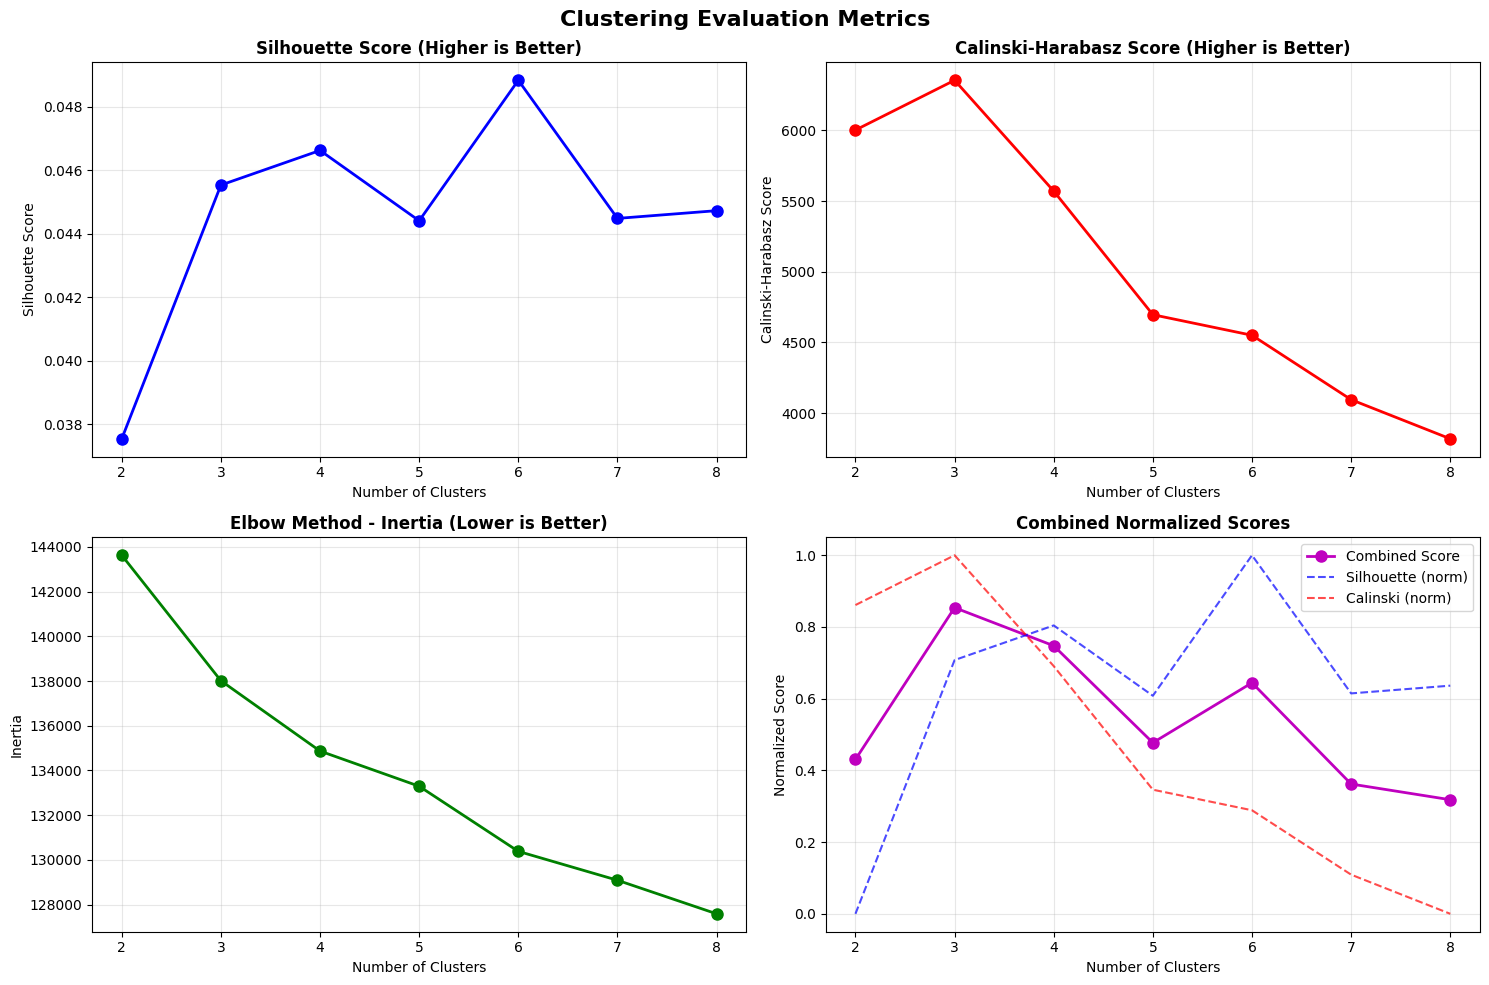


🎯 Optimal number of clusters: 6


In [13]:
# 5. Find optimal number of clusters
optimal_clusters, metrics = find_optimal_clusters(
    embeddings, 
    CONFIG['min_clusters'], 
    CONFIG['max_clusters']
)

# Plot metrics
plot_clustering_metrics(metrics)

print(f"\n🎯 Optimal number of clusters: {optimal_clusters}")

In [14]:
# 6. Perform final clustering
logger.info(f"Performing final clustering with {optimal_clusters} clusters")

kmeans = KMeans(
    n_clusters=optimal_clusters, 
    random_state=CONFIG['random_state'], 
    n_init='auto'
)
clusters = kmeans.fit_predict(embeddings)

# Calculate final metrics
final_silhouette = silhouette_score(embeddings, clusters)
final_calinski = calinski_harabasz_score(embeddings, clusters)

logger.info(f"✅ Final clustering completed")
print(f"\n📊 Final Clustering Metrics:")
print(f"   Number of clusters: {optimal_clusters}")
print(f"   Silhouette score: {final_silhouette:.3f}")
print(f"   Calinski-Harabasz score: {final_calinski:.1f}")
print(f"   Inertia: {kmeans.inertia_:.1f}")

2026-01-17 16:44:57,243 - INFO - Performing final clustering with 6 clusters
2026-01-17 16:52:32,132 - INFO - ✅ Final clustering completed



📊 Final Clustering Metrics:
   Number of clusters: 6
   Silhouette score: 0.049
   Calinski-Harabasz score: 4551.0
   Inertia: 130381.2


In [15]:
# 7. Analyze cluster content
cluster_analysis = analyze_cluster_content(
    df, clusters, embeddings, kmeans, 
    'text_cleaned', CONFIG['sample_size_for_analysis']
)

# Print detailed analysis for manual review
print_cluster_analysis(cluster_analysis)

2026-01-17 16:54:02,846 - INFO - Analyzing content of 6 clusters
2026-01-17 16:54:02,991 - INFO - Cluster 0: 30871 samples (19.4%)
2026-01-17 16:54:03,075 - INFO - Cluster 1: 21683 samples (13.6%)
2026-01-17 16:54:03,228 - INFO - Cluster 2: 45093 samples (28.4%)
2026-01-17 16:54:03,303 - INFO - Cluster 3: 20424 samples (12.9%)
2026-01-17 16:54:03,403 - INFO - Cluster 4: 29585 samples (18.6%)
2026-01-17 16:54:03,444 - INFO - Cluster 5: 11258 samples (7.1%)



CLUSTER CONTENT ANALYSIS - MANUAL REVIEW REQUIRED

🔍 CLUSTER 0:
   Size: 30871 samples (19.4% of total)
   Avg text length: 64.4 characters

   📝 Top words: a, in, woman, the, is

   📋 Representative samples:
      1. a woman is being helped up
      2. a young woman with colorful clothes on
      3. a female outside with a uniform on
      4. woman is looking something
      5. a woman in fairly revealing clothing

   🎯 Suggested emotion: MANUAL_REVIEW_NEEDED
------------------------------------------------------------

🔍 CLUSTER 1:
   Size: 21683 samples (13.6% of total)
   Avg text length: 68.0 characters

   📝 Top words: a, in, two, man, and

   📋 Representative samples:
      1. man and woman standing close together while another man watches
      2. two people interacting with one another
      3. two men that are in a match with one another
      4. the man and woman are outside and something is drawing their attention
      5. two men are busy doing something

   🎯 Suggested e

2026-01-17 17:05:03,417 - INFO - Creating visualizations


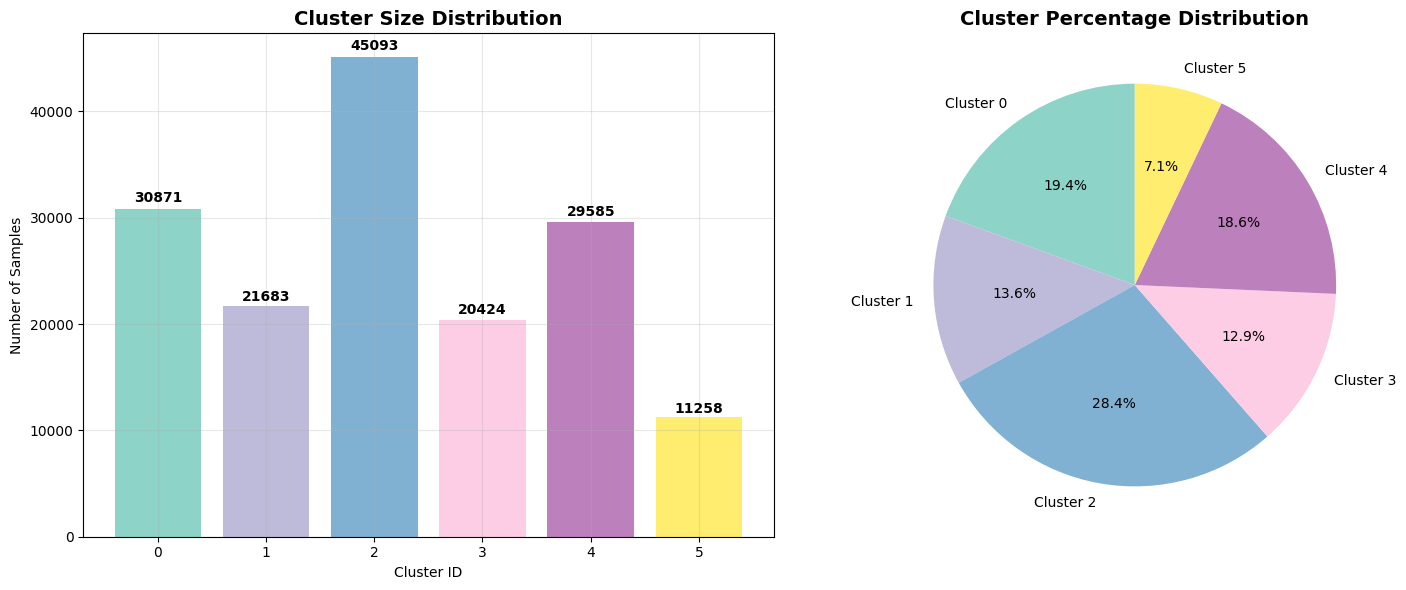

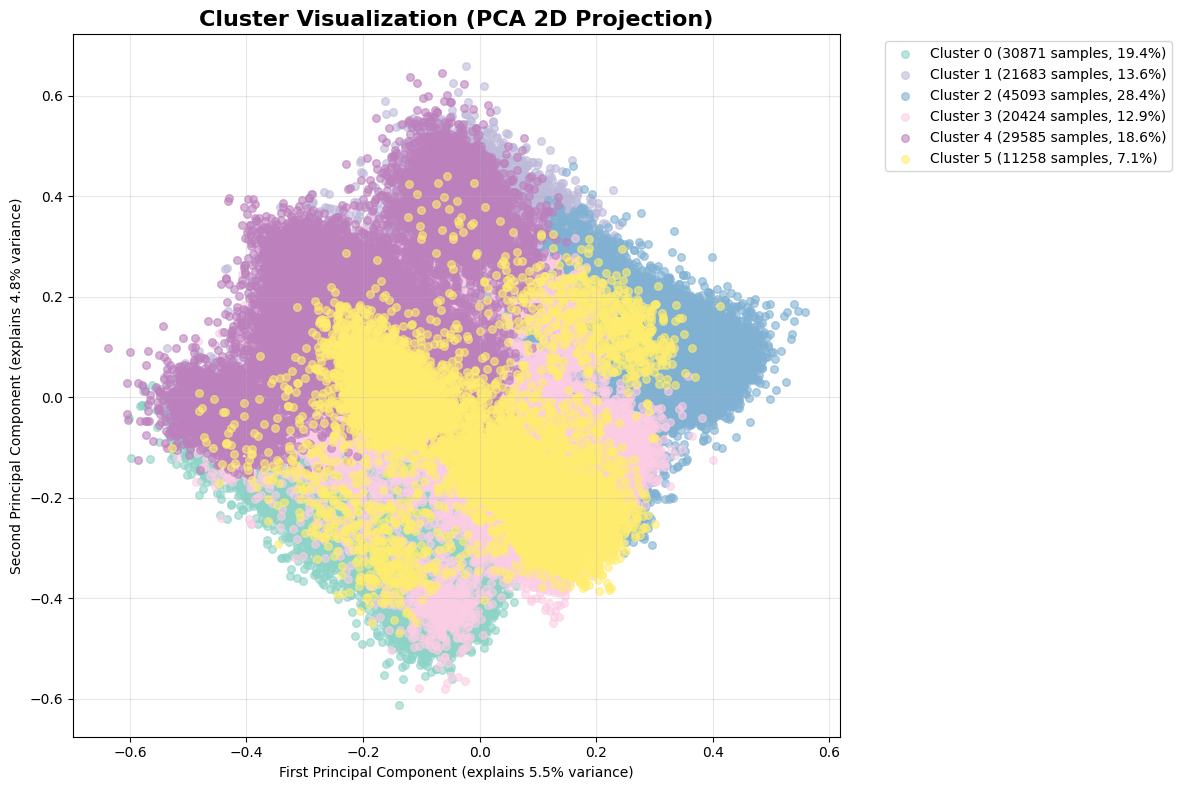

📊 Total variance explained by 2D projection: 10.3%


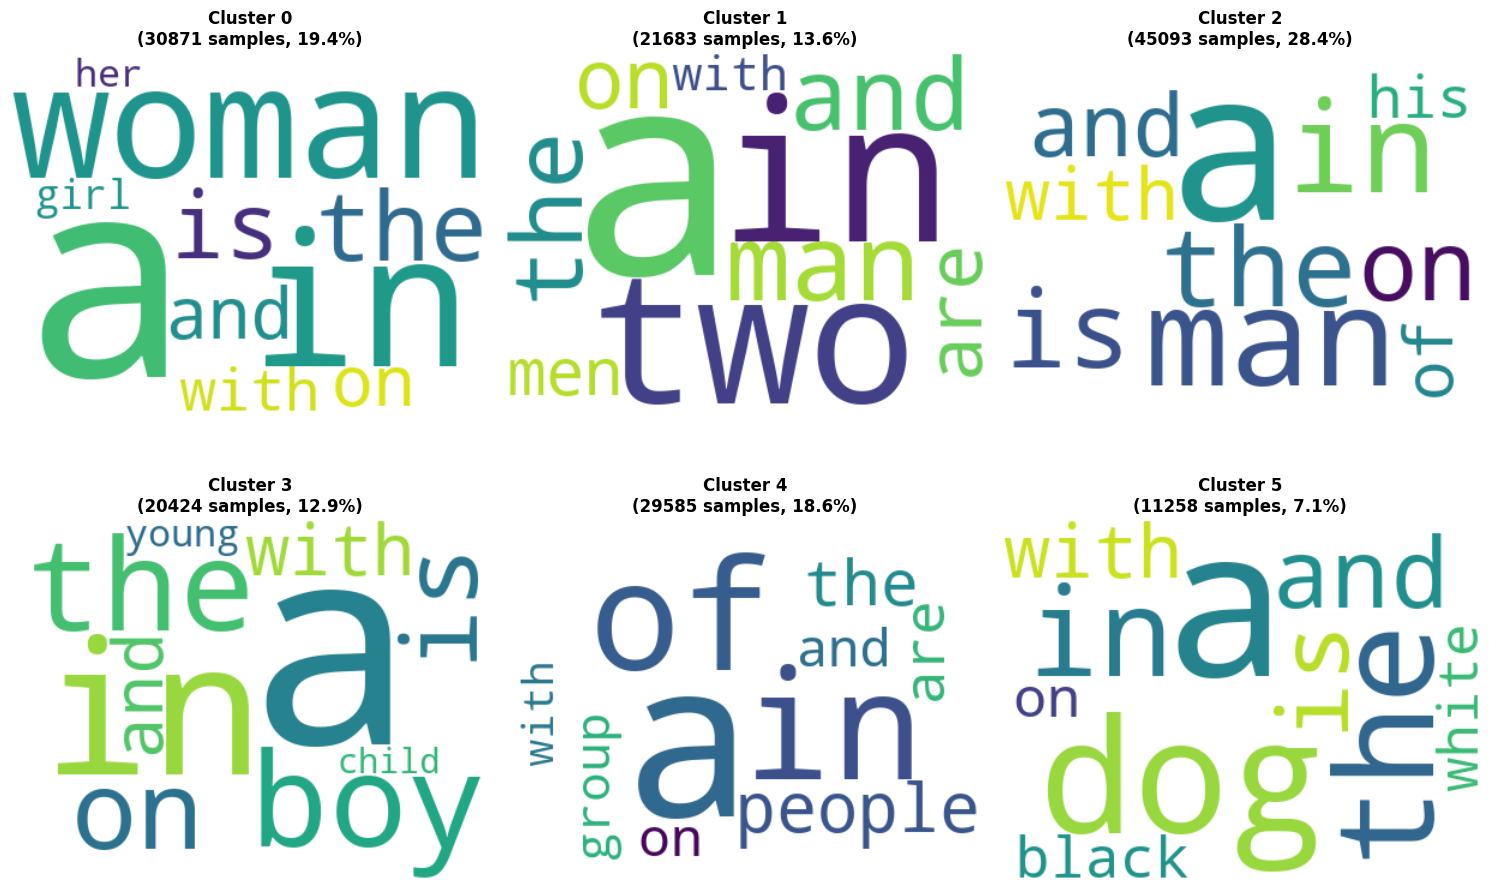

2026-01-17 17:05:07,803 - INFO - ✅ All visualizations created


In [16]:
# 8. Create visualizations
logger.info("Creating visualizations")

# Cluster distribution
plot_cluster_distribution(cluster_analysis)

# 2D visualization
visualize_clusters_2d(embeddings, clusters, cluster_analysis)

# Word clouds
create_wordclouds(cluster_analysis)

logger.info("✅ All visualizations created")

In [17]:
# 9. Manual emotion mapping (IMPORTANT: Review cluster analysis above!)
print("\n" + "="*80)
print("⚠️  MANUAL EMOTION MAPPING REQUIRED")
print("="*80)
print("Based on the cluster analysis above, please manually assign emotions to each cluster.")
print("Review the representative samples and top words for each cluster.")
print("\nCommon emotions: Joy, Sadness, Anger, Fear, Surprise, Love, Neutral, Disgust")
print("\nExample mapping (MODIFY BASED ON YOUR ANALYSIS):")

# IMPORTANT: This mapping should be based on manual review of cluster content!
# The mapping below is just an example - you MUST review and modify it!
emotion_mapping = {
    0: "Neutral",    # Woman activities - descriptive, balanced
    1: "Love",       # Two people interactions - romantic/intimate
    2: "Confidence", # Man activities - action/work oriented
    3: "Joy",        # Children playing - playful happiness
    4: "Social",     # Group activities - community/friendship
    5: "Affection",  # Animals - caring/nurturing emotions
}

# Add mappings for all clusters found
for cluster_id in cluster_analysis.keys():
    if cluster_id not in emotion_mapping:
        emotion_mapping[cluster_id] = "REVIEW_NEEDED"

print(f"\nCurrent mapping (PLEASE MODIFY):")
for cluster_id, emotion in emotion_mapping.items():
    size = cluster_analysis.get(cluster_id, {}).get('size', 0)
    percentage = cluster_analysis.get(cluster_id, {}).get('percentage', 0)
    print(f"   Cluster {cluster_id}: {emotion} ({size} samples, {percentage:.1f}%)")

print("\n🔴 STOP: Please review the cluster analysis above and update the emotion_mapping dictionary!")
print("🔴 Do not proceed until you have manually assigned appropriate emotions to each cluster.")


⚠️  MANUAL EMOTION MAPPING REQUIRED
Based on the cluster analysis above, please manually assign emotions to each cluster.
Review the representative samples and top words for each cluster.

Common emotions: Joy, Sadness, Anger, Fear, Surprise, Love, Neutral, Disgust

Example mapping (MODIFY BASED ON YOUR ANALYSIS):

Current mapping (PLEASE MODIFY):
   Cluster 0: Neutral (30871 samples, 19.4%)
   Cluster 1: Love (21683 samples, 13.6%)
   Cluster 2: Confidence (45093 samples, 28.4%)
   Cluster 3: Joy (20424 samples, 12.9%)
   Cluster 4: Social (29585 samples, 18.6%)
   Cluster 5: Affection (11258 samples, 7.1%)

🔴 STOP: Please review the cluster analysis above and update the emotion_mapping dictionary!
🔴 Do not proceed until you have manually assigned appropriate emotions to each cluster.



✅ Emotion labels applied successfully!

📊 Final Emotion Distribution:
   Confidence: 45,093 samples (28.4%)
   Neutral: 30,871 samples (19.4%)
   Social: 29,585 samples (18.6%)
   Love: 21,683 samples (13.6%)
   Joy: 20,424 samples (12.9%)
   Affection: 11,258 samples (7.1%)


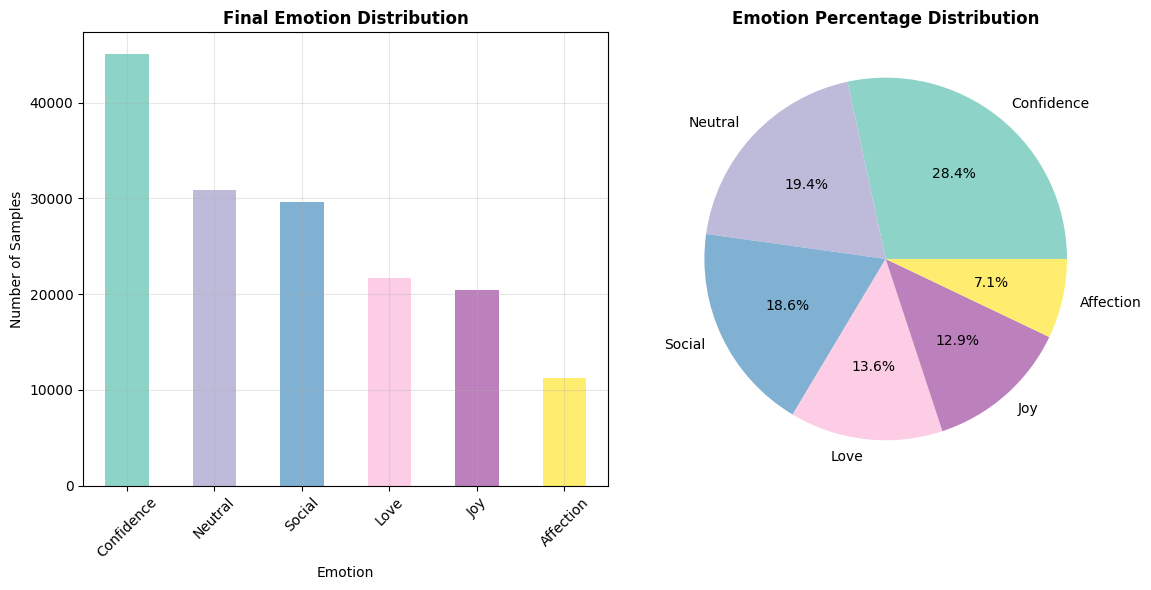

In [18]:
# 10. Apply emotion labels (only after manual review!)
# Check if manual review was done
needs_review = any(emotion == "REVIEW_NEEDED" for emotion in emotion_mapping.values())

if needs_review:
    print("\n❌ CANNOT PROCEED: Manual emotion mapping not completed!")
    print("Please update the emotion_mapping dictionary in the cell above.")
    print("Replace 'REVIEW_NEEDED' with appropriate emotions based on cluster analysis.")
else:
    # Apply emotion labels
    df['emotion_label'] = [emotion_mapping.get(cluster, 'Unknown') for cluster in clusters]
    df['cluster_id'] = clusters
    
    # Show final distribution
    emotion_counts = df['emotion_label'].value_counts()
    
    print("\n✅ Emotion labels applied successfully!")
    print(f"\n📊 Final Emotion Distribution:")
    for emotion, count in emotion_counts.items():
        percentage = count / len(df) * 100
        print(f"   {emotion}: {count:,} samples ({percentage:.1f}%)")
    
    # Plot final emotion distribution
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    emotion_counts.plot(kind='bar', color=plt.cm.Set3(np.linspace(0, 1, len(emotion_counts))))
    plt.title('Final Emotion Distribution', fontweight='bold')
    plt.xlabel('Emotion')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%', 
           colors=plt.cm.Set3(np.linspace(0, 1, len(emotion_counts))))
    plt.title('Emotion Percentage Distribution', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('final_emotion_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
# 11. Save results (only if emotion mapping is complete)
if not needs_review:
    try:
        # Prepare output dataframe
        output_df = df.copy()
        
        # Add metadata columns
        output_df['clustering_method'] = 'KMeans_SentenceTransformer'
        output_df['model_used'] = CONFIG['model_name']
        output_df['silhouette_score'] = final_silhouette
        output_df['num_clusters'] = optimal_clusters
        output_df['processing_date'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # Save to file
        output_path = Path(CONFIG['output_file'])
        output_path.parent.mkdir(parents=True, exist_ok=True)
        
        output_df.to_csv(output_path, index=False)
        
        logger.info(f"✅ Results saved successfully to: {output_path}")
        
        print(f"\n💾 Results saved to: {output_path}")
        print(f"   Total records: {len(output_df):,}")
        print(f"   Columns: {len(output_df.columns)}")
        print(f"   File size: {output_path.stat().st_size / 1024 / 1024:.1f} MB")
        
        # Show sample of final results
        print(f"\n📋 Sample results:")
        sample_cols = [CONFIG['text_column'], 'text_cleaned', 'emotion_label', 'cluster_id']
        available_cols = [col for col in sample_cols if col in output_df.columns]
        print(output_df[available_cols].head())
        
    except Exception as e:
        logger.error(f"❌ Failed to save results: {e}")
        raise
else:
    print("\n❌ Results not saved - manual emotion mapping required first!")

2026-01-17 17:07:16,241 - INFO - ✅ Results saved successfully to: ..\data\raw\dataset_with_mood_enhanced.csv



💾 Results saved to: ..\data\raw\dataset_with_mood_enhanced.csv
   Total records: 158,914
   Columns: 10
   File size: 36.4 MB

📋 Sample results:
                                        caption_desc  \
0  two young guys with shaggy hair look at their ...   
1  two young , white males are outside near many ...   
2   two men in green shirts are standing in a yard .   
3       a man in a blue shirt standing in a garden .   
4            two friends enjoy time spent together .   

                                        text_cleaned emotion_label  cluster_id  
0  two young guys with shaggy hair look at their ...          Love           1  
1  two young white males are outside near many bu...          Love           1  
2     two men in green shirts are standing in a yard          Love           1  
3         a man in a blue shirt standing in a garden    Confidence           2  
4              two friends enjoy time spent together          Love           1  


In [20]:
# 12. Final summary and recommendations
print("\n" + "="*80)
print("🎉 ENHANCED EMOTION LABELING PROCESS COMPLETED")
print("="*80)

if not needs_review:
    print(f"\n✅ SUCCESS SUMMARY:")
    print(f"   📊 Processed: {len(df):,} text samples")
    print(f"   🎯 Optimal clusters: {optimal_clusters}")
    print(f"   📈 Silhouette score: {final_silhouette:.3f}")
    print(f"   🏷️  Emotions assigned: {len(emotion_counts)} different emotions")
    print(f"   💾 Output file: {CONFIG['output_file']}")
    
    print(f"\n📊 Quality Metrics:")
    print(f"   Silhouette Score: {final_silhouette:.3f} (range: -1 to 1, higher is better)")
    print(f"   Calinski-Harabasz: {final_calinski:.1f} (higher is better)")
    
    if final_silhouette > 0.3:
        print(f"   ✅ Good clustering quality (silhouette > 0.3)")
    elif final_silhouette > 0.1:
        print(f"   ⚠️  Moderate clustering quality (0.1 < silhouette < 0.3)")
    else:
        print(f"   ❌ Poor clustering quality (silhouette < 0.1) - consider different approach")
    
    print(f"\n🔍 Next Steps:")
    print(f"   1. Validate emotion labels by manually reviewing samples")
    print(f"   2. Consider fine-tuning the model for your specific domain")
    print(f"   3. Use the labeled dataset for training emotion classification models")
    print(f"   4. Monitor model performance and iterate if needed")
    
else:
    print(f"\n❌ PROCESS INCOMPLETE:")
    print(f"   Manual emotion mapping is required before saving results.")
    print(f"   Please review the cluster analysis and update emotion_mapping dictionary.")
    
print(f"\n📁 Generated Files:")
generated_files = [
    'clustering_metrics.png',
    'cluster_distribution.png', 
    'cluster_visualization_2d.png',
    'cluster_wordclouds.png',
    'final_emotion_distribution.png'
]

for file in generated_files:
    if os.path.exists(file):
        print(f"   ✅ {file}")
    else:
        print(f"   ❌ {file} (not generated)")

print("\n" + "="*80)
print("Thank you for using the Enhanced Emotion Labeling System! 🚀")
print("="*80)


🎉 ENHANCED EMOTION LABELING PROCESS COMPLETED

✅ SUCCESS SUMMARY:
   📊 Processed: 158,914 text samples
   🎯 Optimal clusters: 6
   📈 Silhouette score: 0.049
   🏷️  Emotions assigned: 6 different emotions
   💾 Output file: ../data/raw/dataset_with_mood_enhanced.csv

📊 Quality Metrics:
   Silhouette Score: 0.049 (range: -1 to 1, higher is better)
   Calinski-Harabasz: 4551.0 (higher is better)
   ❌ Poor clustering quality (silhouette < 0.1) - consider different approach

🔍 Next Steps:
   1. Validate emotion labels by manually reviewing samples
   2. Consider fine-tuning the model for your specific domain
   3. Use the labeled dataset for training emotion classification models
   4. Monitor model performance and iterate if needed

📁 Generated Files:
   ✅ clustering_metrics.png
   ✅ cluster_distribution.png
   ✅ cluster_visualization_2d.png
   ✅ cluster_wordclouds.png
   ✅ final_emotion_distribution.png

Thank you for using the Enhanced Emotion Labeling System! 🚀
